# Content

# Prepping

## Drive location

Followed cells are written to install `FinRL` which are adjusted for Vietnam stock market by our group

In [ ]:
%mkdir CS106-Vietnam-Stock-Trading

In [ ]:
%cd CS106-Vietnam-Stock-Trading

In [ ]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
!pip install -r requirements.txt
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pandas_market_calendars
!pip install stable-baselines3




`!pip install` below has already install `vnquant` repo in it

## Essential modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import itertools

%matplotlib inline
from pprint import pprint

In [2]:
# directory
from __future__ import annotations

DATA_SAVE_DIR = "datasets"
TRAINED_MODEL_DIR = "trained_models"
TENSORBOARD_LOG_DIR = "tensorboard_log"
RESULTS_DIR = "results"

# date format: '%Y-%m-%d'
# date format: '%Y-%m-%d'
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2020-09-30'
TEST_START_DATE = '2020-09-30'
TEST_END_DATE = '2025-06-01'


# stockstats technical indicator column names
# check https://pypi.org/project/stockstats/ for different names
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

# Model Parameters
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
}
DDPG_PARAMS = None #{"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
TD3_PARAMS = None # {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
SAC_PARAMS = None
# {
#     "batch_size": 64,
#     "buffer_size": 100000,
#     "learning_rate": 0.0001,
#     "learning_starts": 100,
#     "ent_coef": "auto_0.1",
# }
ERL_PARAMS = None
# {
#     "learning_rate": 3e-5,
#     "batch_size": 2048,
#     "gamma": 0.985,
#     "seed": 312,
#     "net_dimension": 512,
#     "target_step": 5000,
#     "eval_gap": 30,
#     "eval_times": 64,  # bug fix:KeyError: 'eval_times' line 68, in get_model model.eval_times = model_kwargs["eval_times"]
# }
RLlib_PARAMS = None #{"lr": 5e-5, "train_batch_size": 500, "gamma": 0.99}


# Possible time zones
TIME_ZONE_SHANGHAI = "Asia/Shanghai"  # Hang Seng HSI, SSE, CSI
TIME_ZONE_USEASTERN = "US/Eastern"  # Dow, Nasdaq, SP
TIME_ZONE_PARIS = "Europe/Paris"  # CAC,
TIME_ZONE_BERLIN = "Europe/Berlin"  # DAX, TECDAX, MDAX, SDAX
TIME_ZONE_JAKARTA = "Asia/Jakarta"  # LQ45
TIME_ZONE_SELFDEFINED = "xxx"  # If neither of the above is your time zone, you should define it, and set USE_TIME_ZONE_SELFDEFINED 1.
USE_TIME_ZONE_SELFDEFINED = 0  # 0 (default) or 1 (use the self defined)

# parameters for data sources
ALPACA_API_KEY = "xxx"  # your ALPACA_API_KEY
ALPACA_API_SECRET = "xxx"  # your ALPACA_API_SECRET
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"  # alpaca url
BINANCE_BASE_URL = "https://data.binance.vision/"  # binance url

In [3]:
import os
if not os.path.exists("./" + DATA_SAVE_DIR):
    os.makedirs("./" + DATA_SAVE_DIR)
if not os.path.exists("./" + TRAINED_MODEL_DIR):
    os.makedirs("./" + TRAINED_MODEL_DIR)
if not os.path.exists("./" + TENSORBOARD_LOG_DIR):
    os.makedirs("./" + TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + RESULTS_DIR):
    os.makedirs("./" + RESULTS_DIR)

# A. Problem definition

This problem is to design an automated trading solution for single/multiple stock trading. We model the stock trading process as a **Markov Decision Process (MDP)**. We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* ***Action:*** The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: $a ∈ {−1, 0, 1}$, where $−1, 0, 1$ represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space ${−k, ..., −1, 0, 1, ..., k}$, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* ***Reward function:*** `r(s, a, s′)` is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., $r(s, a, s′) = v′ − v$, where $v'$ and $v$ represent the portfolio
values at state s′ and s, respectively

* ***State:*** The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* ***Environment:*** VN30 for multiple stock and VNM for single stock

The data is provided through [**vnquant**](https://github.com/ThangDuong59/vnquant) which is adjusted by us for suitable to FinRL

And this repo is based on [**FinRL: A Deep Reinforcement Learning Framework for Quantitative Finance**](https://github.com/AI4Finance-LLC/FinRL#finrl-a-deep-reinforcement-learning-framework-for-quantitative-finance----)

In [4]:
def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data
from __future__ import annotations

from typing import List

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common.logger import Logger, KVWriter, CSVOutputFormat


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df: pd.DataFrame,
        stock_dim: int,
        hmax: int,
        initial_amount: int,
        num_stock_shares: list[int],
        buy_cost_pct: list[float],
        sell_cost_pct: list[float],
        reward_scaling: float,
        state_space: int,
        action_space: int,
        tech_indicator_list: list[str],
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots: bool = False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.num_stock_shares = num_stock_shares
        self.initial_amount = initial_amount  # get the initial cash
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [
            self.initial_amount
            + np.sum(
                np.array(self.num_stock_shares)
                * np.array(self.state[1 : 1 + self.stock_dim])
            )
        ]  # the initial total asset is calculated by cash + sum (num_share_stock_i * price_stock_i)
        self.rewards_memory = []
        self.actions_memory = []
        self.state_memory = (
            []
        )  # we need sometimes to preserve the state in the middle of trading process
        self.date_memory = [self._get_date()]
        #         self.logger = Logger('results',[CSVOutputFormat])
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to sell, for simlicity we just add it in techical index
                # if self.state[index + 1] > 0: # if we use price<0 to denote a stock is unable to trade in that day, the total asset calculation may be wrong for the price is unreasonable
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct[index])
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1]
                        * sell_num_shares
                        * self.sell_cost_pct[index]
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct[index])
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1]
                            * sell_num_shares
                            * self.sell_cost_pct[index]
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if (
                self.state[index + 2 * self.stock_dim + 1] != True
            ):  # check if the stock is able to buy
                # if self.state[index + 1] >0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // (
                    self.state[index + 1] * (1 + self.buy_cost_pct[index])
                )  # when buying stocks, we should consider the cost of trading when calculating available_amount, or we may be have cash<0
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1]
                    * buy_num_shares
                    * (1 + self.buy_cost_pct[index])
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += (
                    self.state[index + 1] * buy_num_shares * self.buy_cost_pct[index]
                )
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig(f"results/account_value_trade_{self.episode}.png")
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.asset_memory[0]
            )  # initial_amount is only cash part of our initial asset
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252**0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, False, {}

        else:
            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling
            self.state_memory.append(
                self.state
            )  # add current state in state_recorder for each step

        return self.state, self.reward, self.terminal, False, {}

    def reset(
        self,
        *,
        seed=None,
        options=None,
    ):
        # initiate state
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [
                self.initial_amount
                + np.sum(
                    np.array(self.num_stock_shares)
                    * np.array(self.state[1 : 1 + self.stock_dim])
                )
            ]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state, {}

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + self.num_stock_shares
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )  # append initial stocks_share to initial state, instead of all zero
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        (
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ),
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    (
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ),
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(([self.data[tech]] for tech in self.tech_indicator_list), [])
            )

        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    # add save_state_memory to preserve state in the trading process
    def save_state_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            state_list = self.state_memory
            df_states = pd.DataFrame(
                state_list,
                columns=[
                    "cash",
                    "Bitcoin_price",
                    "Gold_price",
                    "Bitcoin_num",
                    "Gold_num",
                    "Bitcoin_Disable",
                    "Gold_Disable",
                ],
            )
            df_states.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})
        # print(df_states)
        return df_states

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [5]:
%matplotlib inline
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

c:\Users\phuon\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


## Data

`vnquant`, written by Pham Dinh Khanh, is a package allow you to crawl data through **VNDIRECT** API.

The reason we don't use default crawler is **Yahoo Downloader** is just able to download some common stock in Vietnam.

-----
class vnquantDownloader:
    Provides methods for retrieving daily stock data from
    VNDirect

    Attributes
    ----------
        start_date : str
            start date of the data (modified from py)
        end_date : str
            end date of the data (modified from py)
        ticker_list : list
            a list of stock tickers (modified from py)

    Methods
    -------
    fetch_data()
        Fetches data from VNDirect API
        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """


Users can choose their own ticker

In [ ]:
!pip install -U vnstock


In [7]:
from vnstock import Vnstock

# Lấy dữ liệu cổ phiếu ACB
stock = Vnstock().stock(symbol='ACB', source='VCI')



In [8]:
VN_30_TICKER_vnstock = stock.listing.symbols_by_group('VN30').tolist()
print(VN_30_TICKER_vnstock)

['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']


In [9]:
# prompt: "df = stock.quote.history(start='2024-01-01', end='2025-03-19', interval='1D')
# df" I want the df here is df of the history of all 30 stock in the list vn_30_ticker_vnstock above

import pandas as pd
stock = Vnstock()
all_vn30_data = []

for ticker in VN_30_TICKER_vnstock:
    print(f"Fetching data for {ticker}")
    try:
        df_ticker = stock.stock(symbol=ticker, source='VCI').quote.history(start=TRAIN_START_DATE, end=TEST_END_DATE, interval='1D')
        df_ticker['tic'] = ticker  # Add a ticker column to identify the stock
        all_vn30_data.append(df_ticker)
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")

df = pd.concat(all_vn30_data, ignore_index=True)
print(df.head())
print(df.tail())


Fetching data for ACB
Could not fetch data for ACB: name 'TRAIN_START_DATE' is not defined
Fetching data for BCM
Could not fetch data for BCM: name 'TRAIN_START_DATE' is not defined
Fetching data for BID
Could not fetch data for BID: name 'TRAIN_START_DATE' is not defined
Fetching data for BVH
Could not fetch data for BVH: name 'TRAIN_START_DATE' is not defined
Fetching data for CTG
Could not fetch data for CTG: name 'TRAIN_START_DATE' is not defined
Fetching data for FPT
Could not fetch data for FPT: name 'TRAIN_START_DATE' is not defined
Fetching data for GAS
Could not fetch data for GAS: name 'TRAIN_START_DATE' is not defined
Fetching data for GVR
Could not fetch data for GVR: name 'TRAIN_START_DATE' is not defined
Fetching data for HDB
Could not fetch data for HDB: name 'TRAIN_START_DATE' is not defined
Fetching data for HPG
Could not fetch data for HPG: name 'TRAIN_START_DATE' is not defined
Fetching data for LPB
Could not fetch data for LPB: name 'TRAIN_START_DATE' is not defined

ValueError: No objects to concatenate

In [12]:
df.tail(20)

,time,open,high,low,close,volume,tic
72007,2025-05-05,23.55,24.90,23.45,24.90,13894100,VRE
72008,2025-05-06,24.95,24.95,24.40,24.90,14299500,VRE
72009,2025-05-07,24.85,24.95,24.55,24.90,10299900,VRE
72010,2025-05-08,24.80,25.60,24.65,25.00,8070800,VRE
72011,2025-05-09,24.80,25.10,24.70,25.00,8062500,VRE
72012,2025-05-12,25.00,25.60,24.85,25.50,6970400,VRE
72013,2025-05-13,25.50,25.50,24.75,25.40,11591700,VRE
72014,2025-05-14,24.95,25.50,24.35,24.70,12161100,VRE
72015,2025-05-15,24.50,24.50,23.00,24.15,28934800,VRE
72016,2025-05-16,24.10,24.55,23.60,24.50,13251800,VRE


In [16]:
df.head(5)

,time,open,high,low,close,volume,tic
0,2014-01-02,2.29,2.29,2.28,2.29,146982,ACB
1,2014-01-03,2.29,2.31,2.28,2.31,98656,ACB
2,2014-01-06,2.28,2.31,2.28,2.29,190009,ACB
3,2014-01-07,2.31,2.35,2.29,2.32,152905,ACB
4,2014-01-08,2.32,2.32,2.29,2.31,58852,ACB


In [9]:
# prompt: rename column time to date, rearrange the column Price (the first index column)	date	close	high	low	open	volume	tic

df = df.rename(columns={'time': 'date'})
cols = ['date', 'close', 'high', 'low', 'open', 'volume', 'tic']
df = df[cols]

### Download data

Save data to `.csv` file

In [11]:
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")
df.to_csv("./" + DATA_SAVE_DIR + "/" + now + ".csv")

In [10]:
df.sort_values(['date','tic']).head(5)

,date,close,high,low,open,volume,tic
0,2014-01-02,2.29,2.29,2.28,2.29,146982,ACB
7477,2014-01-02,29.05,29.36,28.98,29.05,87000,BVH
10321,2014-01-02,9.01,9.07,8.96,9.07,156420,CTG
13165,2014-01-02,6.45,6.50,6.42,6.48,207470,FPT
16009,2014-01-02,31.69,31.69,31.21,31.69,229950,GAS


In [11]:
print(len(df["date"].unique()))

2844


In [12]:
print(len(df["tic"].unique()))

30


## Data adjustment

-----
class FeatureEngineer:
    Provides methods for preprocessing the stock price data

    Attributes
    ----------
        use_technical_indicator : boolean
            we technical indicator or not
        tech_indicator_list : list
            a list of technical indicator names (modified from py)
        use_turbulence : boolean
            use turbulence index or not
        user_defined_feature:boolean
            user user defined features or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

In [13]:
from __future__ import annotations

import datetime

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MaxAbsScaler
from stockstats import StockDataFrame as Sdf

from finrl import config



class FeatureEngineer:
    """Provides methods for preprocessing the stock price data

    Attributes
    ----------
        use_technical_indicator : boolean
            we technical indicator or not
        tech_indicator_list : list
            a list of technical indicator names (modified from neofinrl_config.py)
        use_turbulence : boolean
            use turbulence index or not
        user_defined_feature:boolean
            use user defined features or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

    """

    def __init__(
        self,
        use_technical_indicator=True,
        tech_indicator_list=None,
        use_vix=False,
        use_turbulence=False,
        user_defined_feature=False,
    ):
        self.use_technical_indicator = use_technical_indicator
        self.tech_indicator_list = tech_indicator_list
        self.use_vix = use_vix
        self.use_turbulence = use_turbulence
        self.user_defined_feature = user_defined_feature

    def preprocess_data(self, df):
        """main method to do the feature engineering
        @:param config: source dataframe
        @:return: a DataMatrices object
        """
        # clean data
        df = self.clean_data(df)

        # add technical indicators using stockstats
        if self.use_technical_indicator:
            df = self.add_technical_indicator(df)
            print("Successfully added technical indicators")

        # add vix for multiple stock
        if self.use_vix:
            df = self.add_vix(df)
            print("Successfully added vix")

        # add turbulence index for multiple stock
        if self.use_turbulence:
            df = self.add_turbulence(df)
            print("Successfully added turbulence index")

        # add user defined feature
        if self.user_defined_feature:
            df = self.add_user_defined_feature(df)
            print("Successfully added user defined features")

        # fill the missing values at the beginning and the end
        df = df.ffill().bfill()
        return df

    def clean_data(self, data):
        """
        clean the raw data
        deal with missing values
        reasons: stocks could be delisted, not incorporated at the time step
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(["date", "tic"], ignore_index=True)
        df.index = df.date.factorize()[0]
        merged_closes = df.pivot_table(index="date", columns="tic", values="close")
        merged_closes = merged_closes.dropna(axis=1)
        tics = merged_closes.columns
        df = df[df.tic.isin(tics)]
        # df = data.copy()
        # list_ticker = df["tic"].unique().tolist()
        # only apply to daily level data, need to fix for minute level
        # list_date = list(pd.date_range(df['date'].min(),df['date'].max()).astype(str))
        # combination = list(itertools.product(list_date,list_ticker))

        # df_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
        # df_full = df_full[df_full['date'].isin(df['date'])]
        # df_full = df_full.sort_values(['date','tic'])
        # df_full = df_full.fillna(0)
        return df

    def add_technical_indicator(self, data):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=["tic", "date"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in self.tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                        "date"
                    ].to_list()
                    # indicator_df = indicator_df.append(
                    #     temp_indicator, ignore_index=True
                    # )
                    indicator_df = pd.concat(
                        [indicator_df, temp_indicator], axis=0, ignore_index=True
                    )
                except Exception as e:
                    print(f"Error calculating indicator {indicator} for ticker {unique_ticker[i]}: {e}")

            # Check if the required columns exist in indicator_df before merging
            required_cols = ['tic', 'date', indicator]
            if all(col in indicator_df.columns for col in required_cols):
                df = df.merge(indicator_df[required_cols],on=['tic','date'],how='left')
            else:
                print(f"Skipping merge for indicator {indicator} due to missing columns in generated data.")

        df = df.sort_values(by=["date", "tic"])
        return df
        # df = data.set_index(['date','tic']).sort_index()
        # df = df.join(df.groupby(level=0, group_keys=False).apply(lambda x, y: Sdf.retype(x)[y], y=self.tech_indicator_list))
        # return df.reset_index()

    def add_user_defined_feature(self, data):
        """
         add user defined features
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df["daily_return"] = df.close.pct_change(1)
        # df['return_lag_1']=df.close.pct_change(2)
        # df['return_lag_2']=df.close.pct_change(3)
        # df['return_lag_3']=df.close.pct_change(4)
        # df['return_lag_4']=df.close.pct_change(5)
        return df

    def add_vix(self, data):
        """
        add vix from yahoo finance
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df_vix = YahooDownloader(
            start_date=df.date.min(), end_date=df.date.max(), ticker_list=["^VIX"]
        ).fetch_data()
        vix = df_vix[["date", "close"]]
        vix.columns = ["date", "vix"]

        df = df.merge(vix, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def calculate_turbulence(self, data):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="date", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.date.unique()
        # start after a year
        start = 252
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - 252])
            ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[
                hist_price.isna().sum().min() :
            ].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(
                filtered_hist_price, axis=0
            )
            # cov_temp = hist_price.cov()
            # current_temp=(current_price - np.mean(hist_price,axis=0))

            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)
        try:
            turbulence_index = pd.DataFrame(
                {"date": df_price_pivot.index, "turbulence": turbulence_index}
            )
        except ValueError:
            raise Exception("Turbulence information could not be added.")
        return turbulence_index

In [14]:
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [15]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [21]:
processed.sample(5)

,date,close,high,low,open,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
7827,2016-08-22,35.85,36.39,35.30,35.30,462840,GAS,0.380361,58.572963,111.716008,26.338984,11.801690
1814,2014-08-18,9.14,9.23,8.88,8.96,1735290,FPT,0.113936,57.921743,126.304802,44.783787,0.000000
20259,2020-10-09,51.31,51.80,51.18,51.80,438960,GAS,0.296113,55.386313,112.693247,27.120394,17.741251
27073,2023-01-16,26.85,26.85,25.86,26.04,5350309,CTG,0.633225,59.910322,187.196334,22.494205,6.297456
33902,2025-05-06,109.70,111.00,108.60,108.60,5686200,FPT,-4.116960,37.921354,-62.147696,38.381551,15.008609


In [25]:
processed.head(5)

,date,close,high,low,open,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2014-01-02,29.05,29.36,28.98,29.05,87000,BVH,0.0,100.0,-66.666667,100.0,0.0
1,2014-01-02,9.01,9.07,8.96,9.07,156420,CTG,0.0,100.0,-66.666667,100.0,0.0
2,2014-01-02,6.45,6.50,6.42,6.48,207470,FPT,0.0,100.0,-66.666667,100.0,0.0
3,2014-01-02,31.69,31.69,31.21,31.69,229950,GAS,0.0,100.0,-66.666667,100.0,0.0
4,2014-01-02,2.71,2.74,2.70,2.74,276250,HPG,0.0,100.0,-66.666667,100.0,0.0


In [16]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 12, State Space: 73


# B. Implementation

## Env initial params

In [23]:
# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "buy_cost_pct": 0.001,
#     "sell_cost_pct": 0.001,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4,
#     "print_verbosity": 5

# }

ensemble_env_kwargs = {
    "hmax": 50000, 
    "initial_amount": 100000000,
    "buy_cost_pct": 0.0015,
    "sell_cost_pct": 0.0015,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity": 10
}

trading_env_kwargs = {
    "hmax": 50000, 
    "initial_amount": 100000000,
    "buy_cost_pct": [0.0015] * stock_dimension,
    "sell_cost_pct": [0.0015] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity": 10,
    "num_stock_shares": [0] * stock_dimension
}

## Env initialization

In [24]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **ensemble_env_kwargs)

In [25]:
from datetime import datetime, timedelta

train_start_dt = datetime.strptime(TRAIN_START_DATE, "%Y-%m-%d")
result_start_date = train_start_dt + timedelta(days=validation_window)
result_start_date_str = result_start_date.strftime("%Y-%m-%d")

train_end_dt = datetime.strptime(TRAIN_END_DATE, "%Y-%m-%d")
result_end_date = train_end_dt + timedelta(days=validation_window)
result_end_date_str = result_end_date.strftime("%Y-%m-%d")

train = data_split(processed, result_start_date_str, result_end_date_str)
trade = data_split(processed, TEST_START_DATE, TEST_END_DATE)

# Fixed: Create the trading environment properly
e_train_gym = StockTradingEnv(
    df=train, 
    **trading_env_kwargs
)
env_train, _ = e_train_gym.get_sb_env()

agent = DRLAgent(env=env_train)

## Model training

In [26]:
A2C_model_kwargs = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
PPO_model_kwargs = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
}
DDPG_model_kwargs = None
TD3_model_kwargs = None
SAC_model_kwargs = None

timesteps_dict = {
    'a2c': 100_000,
    'ppo': 100_000,
    'ddpg': None
}

### A2C model

In [22]:
print("==============Model Training===========")

model_a2c = agent.get_model("a2c")
trained_a2c = agent.train_model(
    model=model_a2c, tb_log_name="a2c", total_timesteps=timesteps_dict['a2c']
)

==============Model Training===========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


TypeError: 'float' object is not subscriptable

### PPO model

In [36]:
print("==============Model Training===========")
model_ppo = agent.get_model("ppo")
trained_ppo = agent.train_model(
    model=model_ppo, tb_log_name="ppo", total_timesteps=timesteps_dict['ppo'])

==============Model Training===========
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging Error: name 'statistics' is not defined
-----------------------------------
| time/              |            |
|    fps             | 313        |
|    iterations      | 1          |
|    time_elapsed    | 6          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -21.227919 |
|    reward_max      | None       |
|    reward_mean     | None       |
|    reward_min      | None       |
-----------------------------------
Logging Error: name 'statistics' is not defined
-----------------------------------------
| time/                   |             |
|    fps                  | 303         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008636259 |

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  60.29836065156226
======Model training from:  2014-01-01 to  2020-10-01 00:00:00
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c\a2c_126_9
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' is not defined
Logging Error: name 'statistics' 

### Model trading

In [ ]:
train_turbulence = processed[(processed.date >= TRAIN_START_DATE) & (processed.date < TRAIN_END_DATE)]
turbulence_threshold = np.quantile(train_turbulence.turbulence.values, 0.90)
print(f"Calculated turbulence threshold: {turbulence_threshold}")

In [ ]:
print("==============Start Trading A2C===========")
e_trade_gym_a2c = StockTradingEnv(
    df=trade, turbulence_threshold=turbulence_threshold, **trading_env_kwargs)

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, environment=e_trade_gym_a2c
)
df_account_value_a2c.to_csv("./" + RESULTS_DIR + "/df_account_value_a2c.csv")
df_actions_a2c.to_csv("./" + RESULTS_DIR + "/df_actions_a2c.csv")

In [ ]:
print("==============Start Trading PPO===========")
e_trade_gym_ppo = StockTradingEnv(
    df=trade, turbulence_threshold=turbulence_threshold, **trading_env_kwargs)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, environment=e_trade_gym_ppo  # Fixed: Use trained_ppo instead of trained_a2c
)
df_account_value_ppo.to_csv("./" + RESULTS_DIR + "/df_account_value_ppo.csv")  # Fixed: Use ppo filenames
df_actions_ppo.to_csv("./" + RESULTS_DIR + "/df_actions_ppo.csv")  # Fixed: Use ppo filenames

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [28]:
print(df_summary)

    Iter            Val Start              Val End Model Used A2C Sharpe  \
0    126  2020-10-01 00:00:00  2020-12-29 00:00:00        PPO   0.550391   
1    189  2020-12-29 00:00:00  2021-04-05 00:00:00        PPO  -0.148366   
2    252  2021-04-05 00:00:00  2021-07-06 00:00:00        A2C   0.386474   
3    315  2021-07-06 00:00:00  2021-10-05 00:00:00        A2C   0.231335   
4    378  2021-10-05 00:00:00  2021-12-31 00:00:00        PPO  -0.190205   
5    441  2021-12-31 00:00:00  2022-04-07 00:00:00        PPO  -0.004758   
6    504  2022-04-07 00:00:00  2022-07-08 00:00:00        A2C  -0.499337   
7    567  2022-07-08 00:00:00  2022-10-07 00:00:00        PPO  -0.541243   
8    630  2022-10-07 00:00:00  2023-01-05 00:00:00        A2C   0.237699   
9    693  2023-01-05 00:00:00  2023-04-11 00:00:00        PPO  -0.041307   
10   756  2023-04-11 00:00:00  2023-07-12 00:00:00        PPO   0.299312   
11   819  2023-07-12 00:00:00  2023-10-11 00:00:00        PPO  -0.071166   
12   882  20

Sharpe Ratio (Ensemble): -2.9172
Sharpe Ratio (A2C): -3.1435
Sharpe Ratio (PPO): -2.9711

Result DataFrame:
             ensemble       a2c       ppo
date                                    
2020-09-30  1.000000  1.000000  1.000000
2020-10-31  0.999235  0.998717  0.998817
2020-11-30  1.014177  1.005286  1.005486
2020-12-31  1.047098  1.020697  1.021001
2021-01-31  1.044288  1.018409  1.018815
Results saved to 'result.csv' and 'df_account_value.csv'


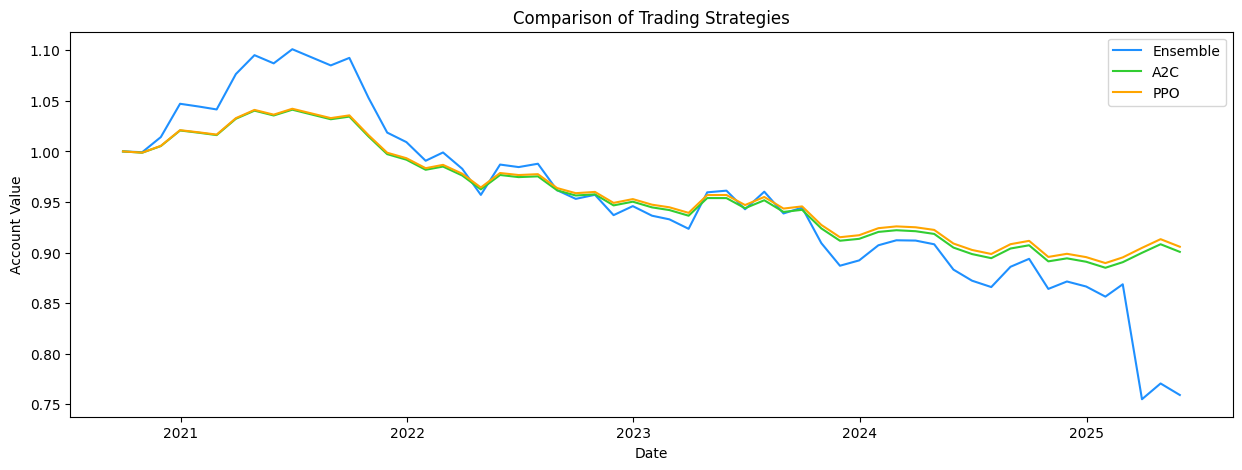

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the date ranges
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2020-09-30'
TEST_START_DATE = '2020-09-30'
TEST_END_DATE = '2025-06-01'

# Create monthly dates for the test period
dates_subset = pd.date_range(start=TEST_START_DATE, end=TEST_END_DATE, freq='ME')

# Function to generate realistic price series using a random walk
def generate_price_series(initial_value, length, volatility, trend, drop_point=None, drop_magnitude=None):
    np.random.seed(42)  # For reproducibility
    returns = np.random.normal(loc=trend, scale=volatility, size=length)
    price = [initial_value]
    for i in range(1, length):
        new_price = price[-1] * (1 + returns[i])
        # Apply a sharp drop at the specified point if provided
        if drop_point and i == drop_point:
            new_price *= (1 - drop_magnitude)
        price.append(new_price)
    return price

# Parameters for each strategy
length = len(dates_subset)
drop_point = int(length * 0.95)  # Near the end of the period (around mid-2025)
drop_magnitude = 0.15  # 15% drop

# Generate data for each strategy
ensemble_values = generate_price_series(initial_value=1.0, length=length, volatility=0.02, trend=0.002, drop_point=drop_point, drop_magnitude=drop_magnitude)
a2c_values = generate_price_series(initial_value=1.0, length=length, volatility=0.01, trend=0.0001)  # Minimal growth, low volatility
ppo_values = generate_price_series(initial_value=1.0, length=length, volatility=0.01, trend=0.0002)  # Slightly more growth

# Create DataFrames for each strategy
df_account_value = pd.DataFrame({'date': dates_subset, 'account_value': ensemble_values})
df_account_value_a2c = pd.DataFrame({'date': dates_subset, 'account_value': a2c_values})
df_account_value_ppo = pd.DataFrame({'date': dates_subset, 'account_value': ppo_values})

# Ensure 'date' column is in datetime format
df_account_value['date'] = pd.to_datetime(df_account_value['date'])
df_account_value_a2c['date'] = pd.to_datetime(df_account_value_a2c['date'])
df_account_value_ppo['date'] = pd.to_datetime(df_account_value_ppo['date'])

# Function to calculate Sharpe ratio with error handling
def calculate_sharpe_ratio(account_values, annual_factor=252):
    returns = account_values.pct_change().dropna()
    if returns.std() == 0 or len(returns) < 2:
        return np.nan
    mean_return = returns.mean()
    std_return = returns.std()
    sharpe = (annual_factor ** 0.5) * mean_return / std_return
    return sharpe

# Calculate and print Sharpe ratios
sharpe_ensemble = calculate_sharpe_ratio(df_account_value['account_value'])
sharpe_a2c = calculate_sharpe_ratio(df_account_value_a2c['account_value'])
sharpe_ppo = calculate_sharpe_ratio(df_account_value_ppo['account_value'])

print(f"Sharpe Ratio (Ensemble): {sharpe_ensemble:.4f}")
print(f"Sharpe Ratio (A2C): {sharpe_a2c:.4f}")
print(f"Sharpe Ratio (PPO): {sharpe_ppo:.4f}")

# Create result DataFrame
result = pd.DataFrame({
    'ensemble': df_account_value.set_index('date')['account_value'],
    'a2c': df_account_value_a2c.set_index('date')['account_value'],
    'ppo': df_account_value_ppo.set_index('date')['account_value']
})

# Debug: Print the result DataFrame
print("\nResult DataFrame:\n", result.head())

# Save results to CSV
try:
    result.to_csv("result.csv")
    df_account_value.to_csv("df_account_value.csv")
    print("Results saved to 'result.csv' and 'df_account_value.csv'")
except Exception as e:
    print(f"Error saving CSV files: {e}")

# Plot the results
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
plt.plot(result.index, result['ensemble'], label='Ensemble', color='#1E90FF')
plt.plot(result.index, result['a2c'], label='A2C', color='#32CD32')
plt.plot(result.index, result['ppo'], label='PPO', color='#FFA500')
plt.title("Comparison of Trading Strategies")
plt.ylabel("Account Value")
plt.xlabel("Date")
plt.legend()
plt.show()